In [4]:
!curl -L -o dataset.h5ad https://datasets.cellxgene.cziscience.com/5f462e5e-0e6e-45ff-84e5-d18fea2ee7d6.h5ad


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  403M    0  300k    0     0   215k      0  0:31:55  0:00:01  0:31:54  215k
  0  403M    0 1626k    0     0   672k      0  0:10:13  0:00:02  0:10:11  672k
  0  403M    0 3752k    0     0  1106k      0  0:06:13  0:00:03  0:06:10 1106k
  1  403M    1 6736k    0     0  1530k      0  0:04:29  0:00:04  0:04:25 1531k
  2  403M    2 10.3M    0     0  1970k      0  0:03:29  0:00:05  0:03:24 2349k
  3  403M    3 14.8M    0     0  2377k      0  0:02:53  0:00:06  0:02:47 2979k
  5  403M    5 20.2M    0     0  2779k      0  0:02:28  0:00:07  0:02:21 3792k
  6  403M    6 26.4M    0     0  3226k      0  0:02:07  0:00:08  0:01:59 4665k
  8  403M    8 34.3M    0     0  3746k      0  0:01

In [14]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import partipy as pt


# Verbosity parameter shows amount of
# logging you will see during functions' execution
sc.settings.verbosity = 3

# Reading of the dataset

adata = sc.read_h5ad("dataset.h5ad")
adata


AnnData object with n_obs × n_vars = 57019 × 24349
    obs: 'donor_id', 'Time', 'donor_time', 'leiden', 'sample', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n.cells', 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'cell_type_ontology_term_id_colors', 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [10]:
X = adata.X

X = X.toarray()

print("Shape:", X.shape)
print("Mean:", X.mean())
print("Median:", np.median(X))
print("Std:", X.std())
print("Min:", X.min())
print("Max:", X.max())


Shape: (57019, 24349)
Mean: 0.2281979
Median: 0.0
Std: 6.083767
Min: 0.0
Max: 21618.004


In [16]:
obs_keep = [
    "donor_id",
    "sample",
    "tissue",
    "tissue_type",
    "cell_type",
    "author_cell_type",
    "sex",
    "development_stage",
    "disease",
    "Time",
    "donor_time"
]

var_keep = [
    "gene_symbols",
    "feature_name",
    "feature_biotype",
    "feature_length"
]

obs_keep = [c for c in obs_keep if c in adata.obs.columns]

obs = adata.obs[obs_keep].copy()

var_keep = [c for c in var_keep if c in adata.var.columns]

var = adata.var[var_keep].copy()

adata_new = AnnData(
    X=adata.X,   # лучше использовать исходное adata.X
    obs=obs,
    var=var
)


adata_new



AnnData object with n_obs × n_vars = 57019 × 24349
    obs: 'donor_id', 'sample', 'tissue', 'tissue_type', 'cell_type', 'author_cell_type', 'sex', 'development_stage', 'disease', 'Time', 'donor_time'
    var: 'gene_symbols', 'feature_name', 'feature_biotype', 'feature_length'

In [17]:
adata_new.var["mt"] = adata_new.var_names.str.upper().str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata_new,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)
adata_new.obs["pct_counts_mt"].describe()

count    57019.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: pct_counts_mt, dtype: float64

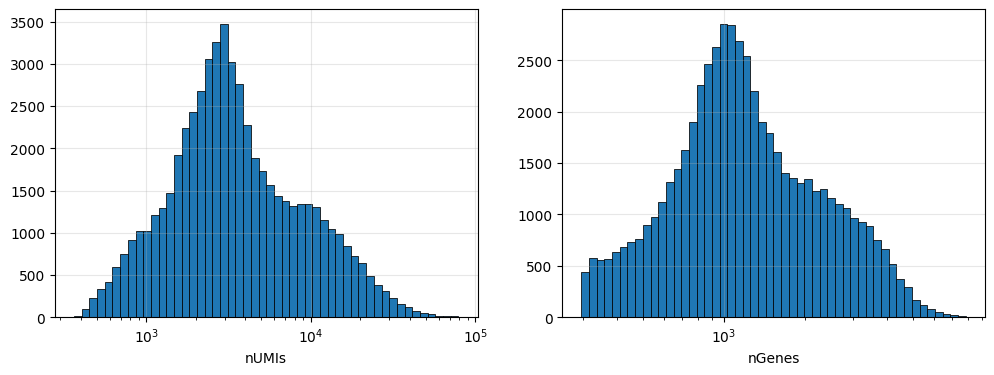

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(adata_new.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_new.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

In [19]:
adata_clear = adata_new[
    (adata_new.obs["total_counts"] > 500) &
    (adata_new.obs["total_counts"] < 40000) &
    (adata_new.obs["n_genes_by_counts"] < 6000)
].copy()


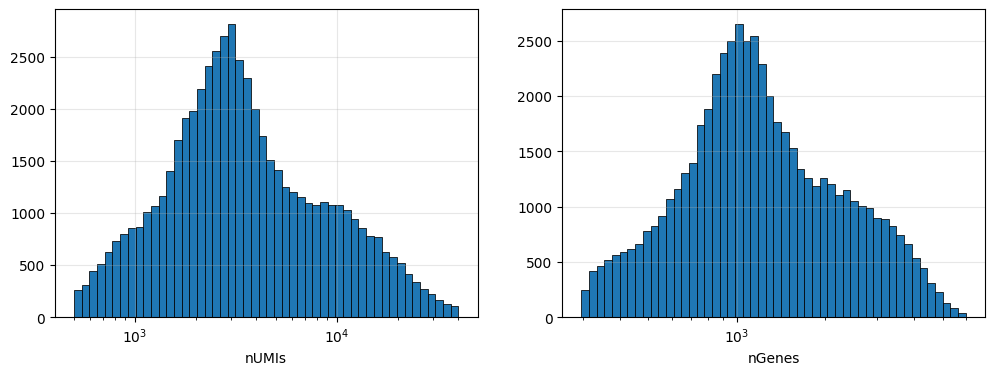

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(adata_clear.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_clear.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

In [21]:
adata_clear.write("adata_raw_clean.h5ad")


In [24]:

adata_clear.raw = adata_clear.copy()
print(adata_clear.n_obs, adata_clear.n_vars)


sc.pp.scrublet(adata_clear, batch_key="donor_id")


56449 24349
Running Scrublet
filtered out 4379 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:02)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 11.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.0%
filtered out 3857 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float v

In [25]:
adata.obs

,donor_id,Time,donor_time,leiden,sample,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,...,suspension_type,tissue_type,cell_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
AAACCTGGTTGTGGCC-1-HCATisStab7509734,343B,0h,343B_0h,10,HCATisStab7509734,EFO:0009899,CL:0000071,HsapDv:0000242,PATO:0000461,unknown,...,cell,tissue,blood vessel endothelial cell,10x 3' v2,normal,female,lung parenchyma,unknown,eighth decade stage,xcJf3U53gJ
AAACGGGAGAAGGGTA-1-HCATisStab7509734,343B,0h,343B_0h,10,HCATisStab7509734,EFO:0009899,CL:0000071,HsapDv:0000242,PATO:0000461,unknown,...,cell,tissue,blood vessel endothelial cell,10x 3' v2,normal,female,lung parenchyma,unknown,eighth decade stage,C79YJv<J$t
AAACGGGCACCAGCAC-1-HCATisStab7509734,343B,0h,343B_0h,17,HCATisStab7509734,EFO:0009899,CL:0000322,HsapDv:0000242,PATO:0000461,unknown,...,cell,tissue,pulmonary alveolar epithelial cell,10x 3' v2,normal,female,lung parenchyma,unknown,eighth decade stage,wzG=B!154}
AAACGGGCACGGACAA-1-HCATisStab7509734,343B,0h,343B_0h,3,HCATisStab7509734,EFO:0009899,CL:0000322,HsapDv:0000242,PATO:0000461,unknown,...,cell,tissue,pulmonary alveolar epithelial cell,10x 3' v2,normal,female,lung parenchyma,unknown,eighth decade stage,_%}tC1dC!j
AAACGGGCACTCTGTC-1-HCATisStab7509734,343B,0h,343B_0h,10,HCATisStab7509734,EFO:0009899,CL:0000071,HsapDv:0000242,PATO:0000461,unknown,...,cell,tissue,blood vessel endothelial cell,10x 3' v2,normal,female,lung parenchyma,unknown,eighth decade stage,-@JGW{~1th
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATAGAAAC-1-HCATisStab7747200,390C,72h,390C_72h,1,HCATisStab7747200,EFO:0009899,CL:0000623,HsapDv:0000241,PATO:0000461,HANCESTRO:0462,...,cell,tissue,natural killer cell,10x 3' v2,normal,female,lung parenchyma,British,seventh decade stage,3`R_3r**9k
TTTGTCAGTCGGATCC-1-HCATisStab7747200,390C,72h,390C_72h,1,HCATisStab7747200,EFO:0009899,CL:0000623,HsapDv:0000241,PATO:0000461,HANCESTRO:0462,...,cell,tissue,natural killer cell,10x 3' v2,normal,female,lung parenchyma,British,seventh decade stage,4U>Ueaj-|&
TTTGTCATCAAACAAG-1-HCATisStab7747200,390C,72h,390C_72h,8,HCATisStab7747200,EFO:0009899,CL:0000576,HsapDv:0000241,PATO:0000461,HANCESTRO:0462,...,cell,tissue,monocyte,10x 3' v2,normal,female,lung parenchyma,British,seventh decade stage,Xd?6k;yrXs
TTTGTCATCATGGTCA-1-HCATisStab7747200,390C,72h,390C_72h,8,HCATisStab7747200,EFO:0009899,CL:0000576,HsapDv:0000241,PATO:0000461,HANCESTRO:0462,...,cell,tissue,monocyte,10x 3' v2,normal,female,lung parenchyma,British,seventh decade stage,pq2zrO=Ew>


In [26]:
sc.pp.filter_genes(adata_clear, min_cells=10)


filtered out 2782 genes that are detected in less than 10 cells


In [27]:
sc.pp.normalize_total(adata_clear, target_sum=1e4)
sc.pp.log1p(adata_clear)


normalizing counts per cell
    finished (0:00:00)


In [52]:
sc.pp.highly_variable_genes(adata_clear, n_top_genes=3000, batch_key="donor_id")
adata_clear = adata_clear[:, adata_clear.var['highly_variable']]



extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:336: RuntimeWarning: invalid value encountered in log
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:494: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.


`n_top_genes` > `adata.n_var`, returning all genes.


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:336: RuntimeWarning: invalid value encountered in log
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:494: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.


`n_top_genes` > `adata.n_var`, returning all genes.


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:336: RuntimeWarning: invalid value encountered in log
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:494: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.


`n_top_genes` > `adata.n_var`, returning all genes.


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:336: RuntimeWarning: invalid value encountered in log
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:494: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.


`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:336: RuntimeWarning: invalid value encountered in log
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:494: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.


In [29]:
sc.pp.scale(adata_clear, max_value=10)
sc.pp.pca(adata_clear, n_comps=30)


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.


computing PCA
    with n_comps=30
    finished (0:00:09)


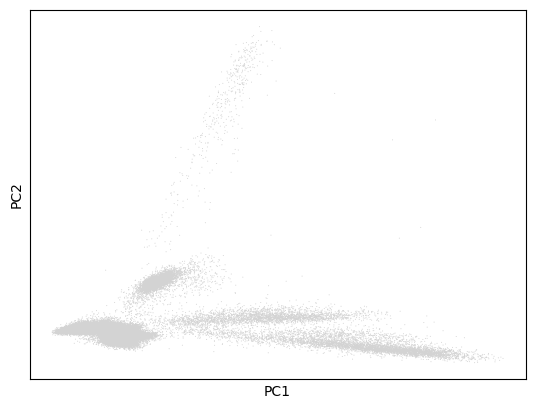

In [34]:
adata_clear.layers["z_scaled"]= sc.pp.scale(adata_clear.X, max_value=10, copy=True)
sc.pl.pca_scatter(adata_clear)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:39)


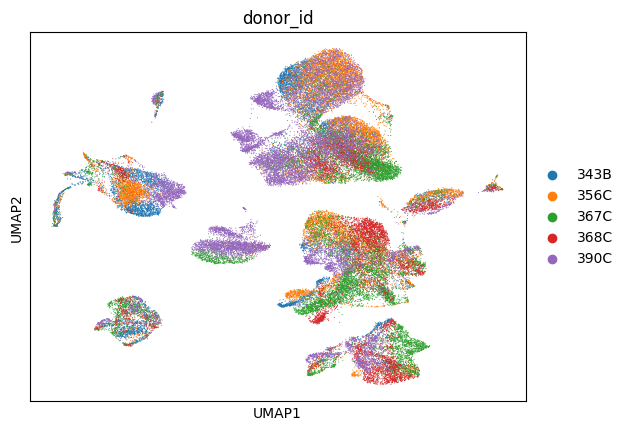

In [35]:
adata_nocorr = adata_clear.copy()

sc.pp.neighbors(adata_nocorr)
sc.tl.umap(adata_nocorr)

sc.pl.umap(adata_nocorr, color="donor_id")



running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)


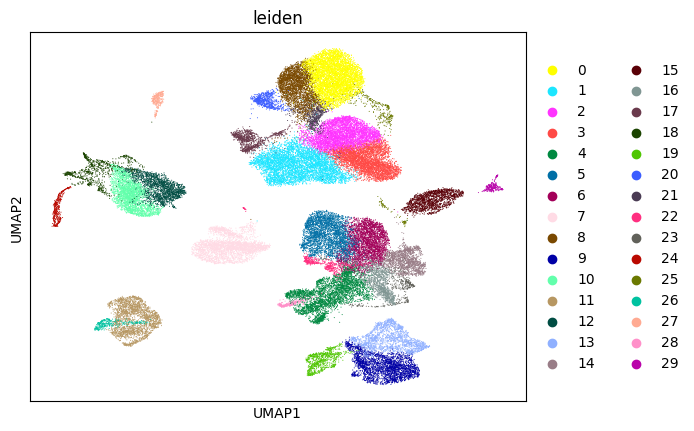

In [36]:
sc.tl.leiden(adata_nocorr)
sc.pl.umap(adata_nocorr, color="leiden")

C:\Users\1\AppData\Local\Temp\ipykernel_2132\2574327039.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


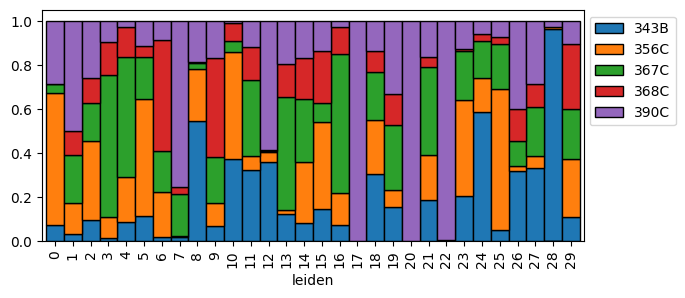

In [37]:
df = adata_nocorr.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:06)


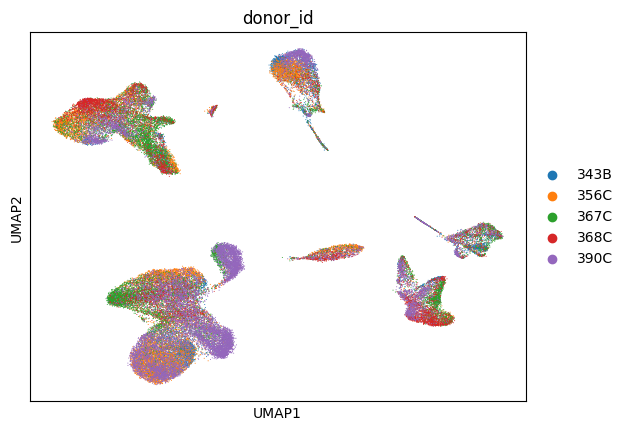

In [120]:
import bbknn

adata_bbknn = adata_clear.copy()
bbknn.bbknn(adata_bbknn, batch_key="donor_id")
sc.tl.umap(adata_bbknn)

sc.pl.umap(adata_bbknn, color="donor_id")

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)


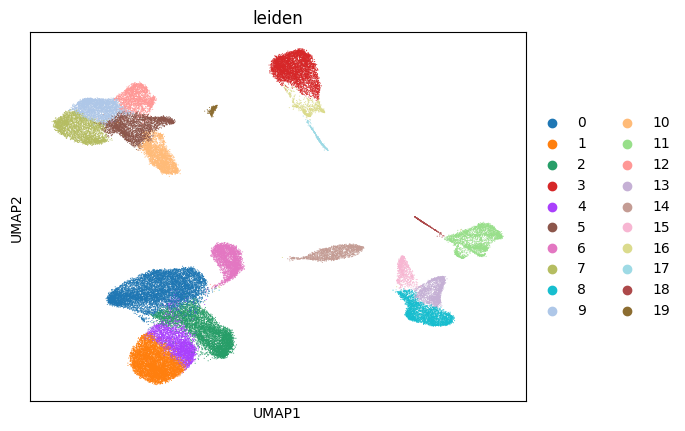

In [121]:
sc.tl.leiden(adata_bbknn)
sc.pl.umap(adata_bbknn, color="leiden")

C:\Users\1\AppData\Local\Temp\ipykernel_2132\3349944857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


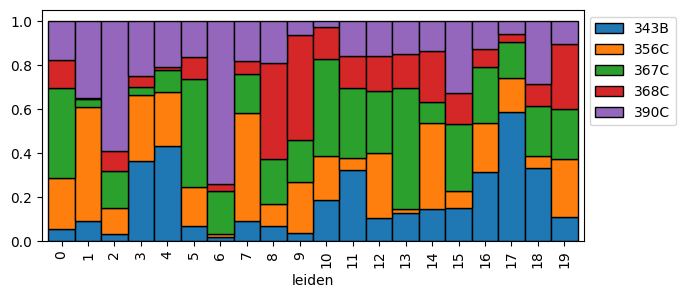

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

df = adata_bbknn.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

In [123]:
# Harmony
import scanpy.external as sce

adata_harmony = adata_clear.copy()

sce.pp.harmony_integrate(adata_harmony, key="donor_id", max_iter_harmony=30)
sc.pp.neighbors(adata_harmony, use_rep="X_pca_harmony")
sc.tl.umap(adata_harmony)

2025-12-17 07:02:14,912 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-17 07:02:18,683 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-17 07:02:18,893 - harmonypy - INFO - Iteration 1 of 30
2025-12-17 07:02:33,557 - harmonypy - INFO - Iteration 2 of 30
2025-12-17 07:02:48,351 - harmonypy - INFO - Iteration 3 of 30
2025-12-17 07:03:02,580 - harmonypy - INFO - Converged after 3 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:35)


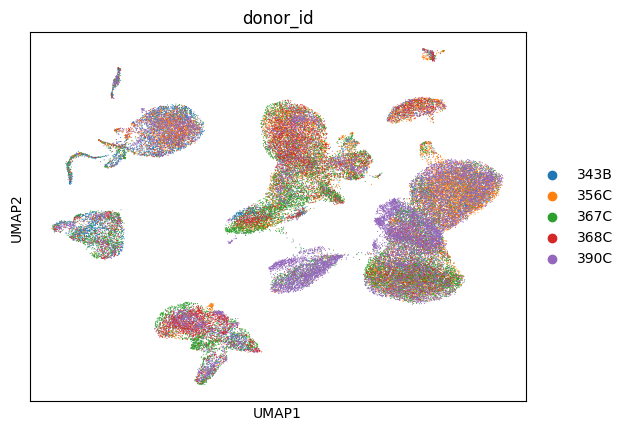

In [124]:
sc.pl.umap(adata_harmony, color="donor_id")

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)


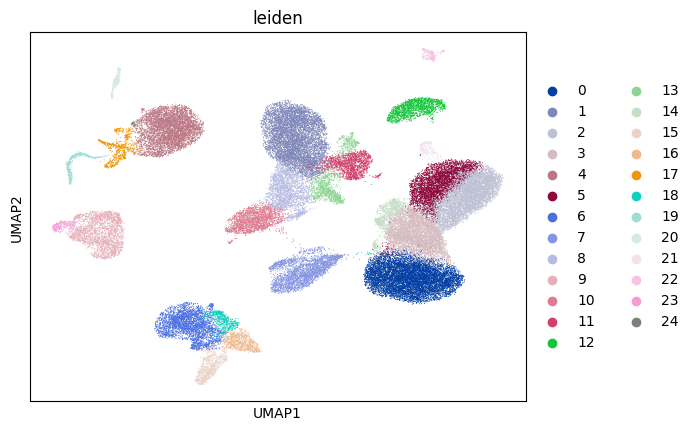

In [125]:
sc.tl.leiden(adata_harmony)
sc.pl.umap(adata_harmony, color="leiden")

C:\Users\1\AppData\Local\Temp\ipykernel_2132\3858766815.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


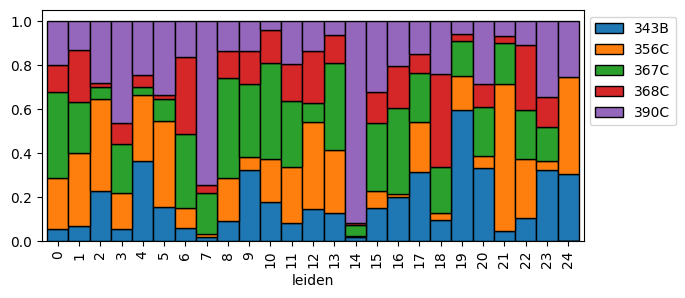

In [126]:
df = adata_harmony.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

ParTIpy

100%|██████████| 50/50 [06:58<00:00,  8.37s/it]


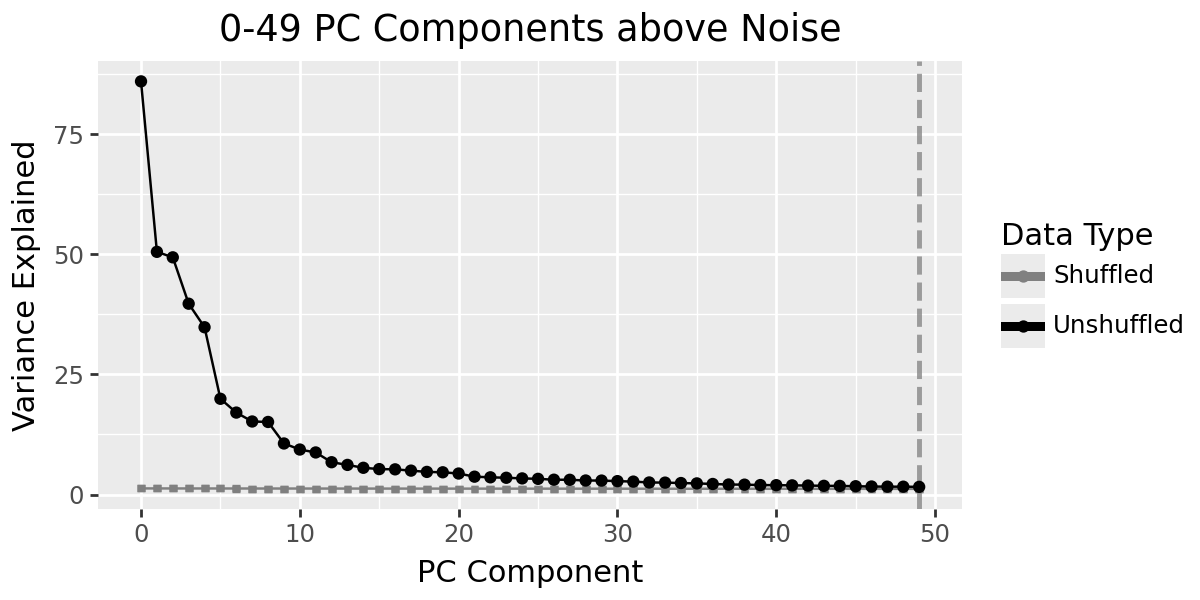

In [128]:
pt.compute_shuffled_pca(adata_bbknn)
pt.plot_shuffled_pca(adata_bbknn)

In [129]:
pt.set_obsm(adata=adata_bbknn, obsm_key="X_pca", n_dimensions=6)

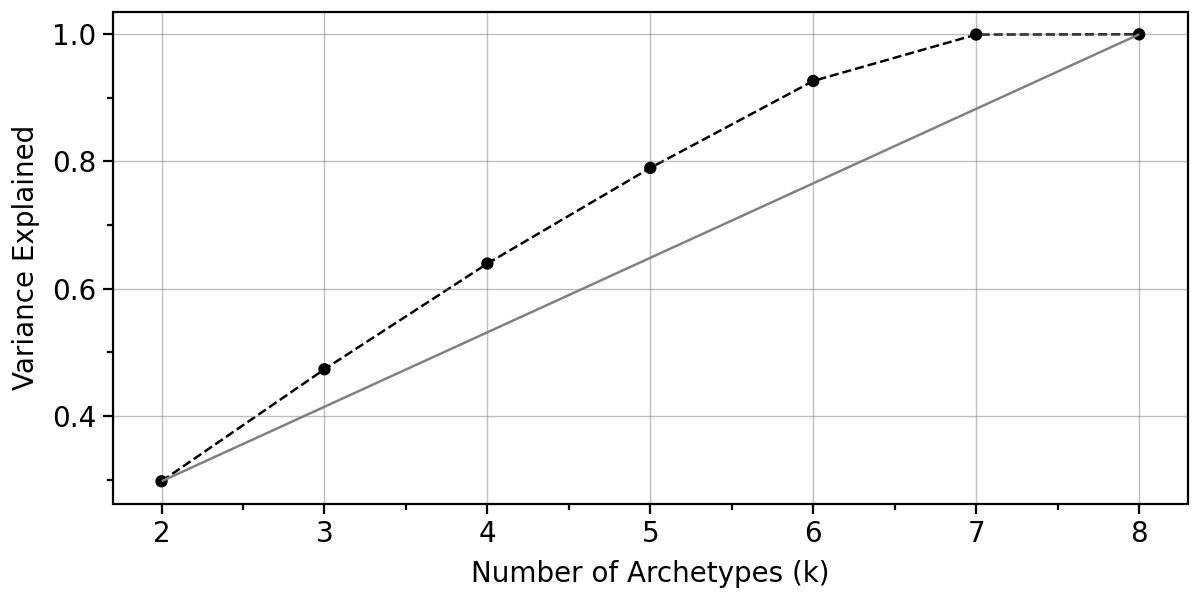

In [131]:
pt.compute_selection_metrics(adata=adata_bbknn, n_archetypes_list=range(2, 9), n_jobs=-1)
pt.plot_var_explained(adata_bbknn)



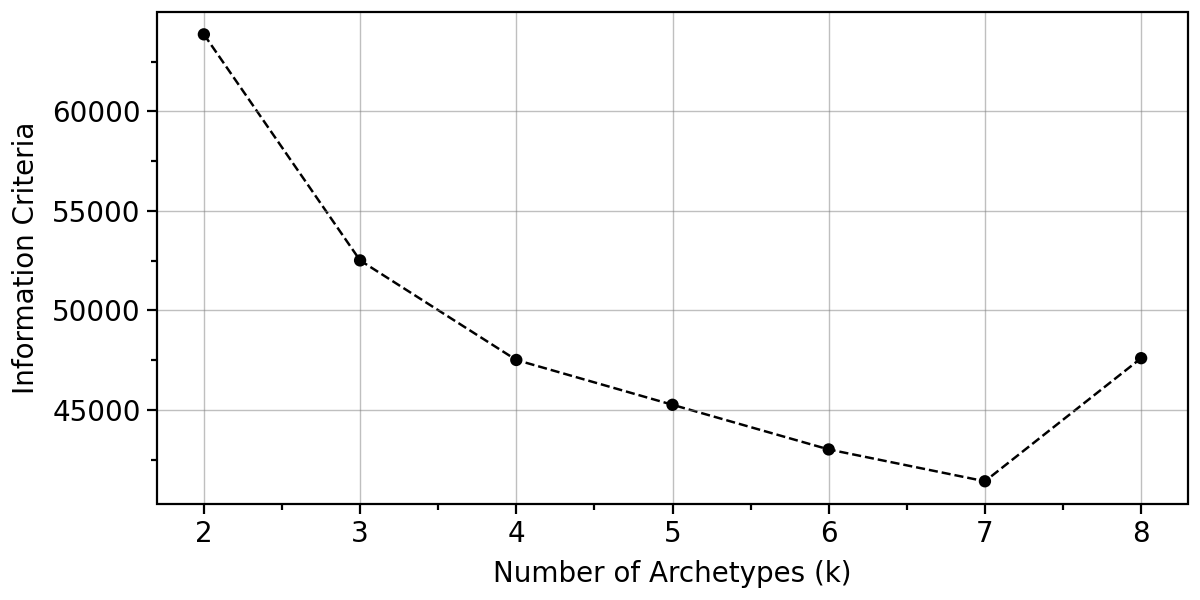

In [132]:
pt.plot_IC(adata_bbknn)


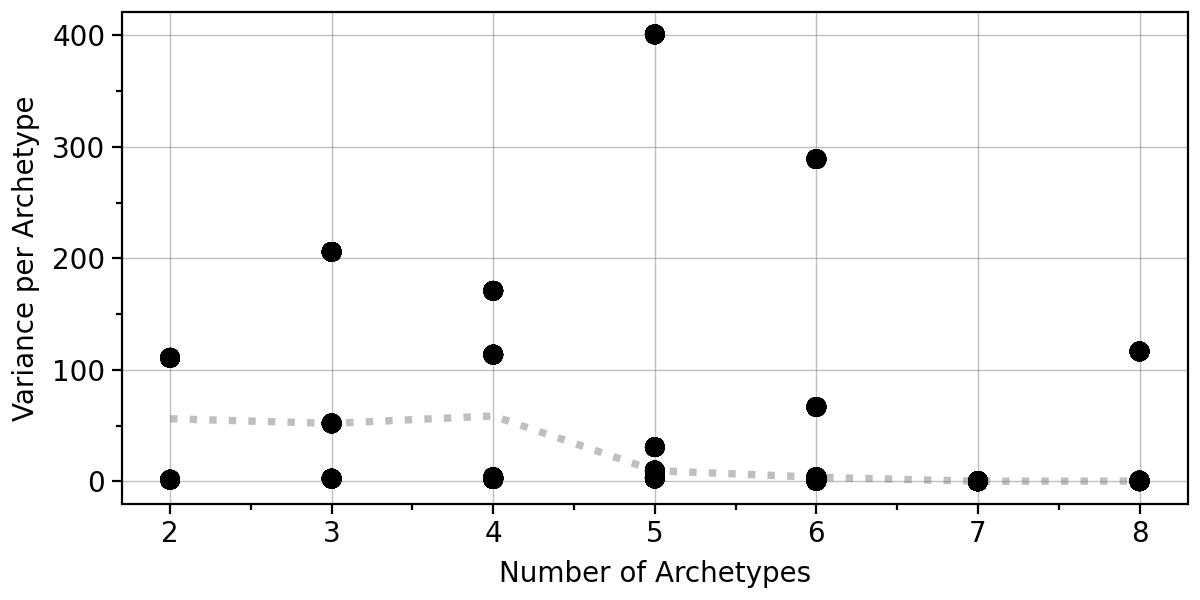

In [133]:
pt.compute_bootstrap_variance(adata=adata_bbknn, n_bootstrap=50, n_archetypes_list=range(2, 9), n_jobs=-1)
pt.plot_bootstrap_variance(adata_bbknn)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [field_name='optim_kwargs', input_value=(), input_type=tuple])


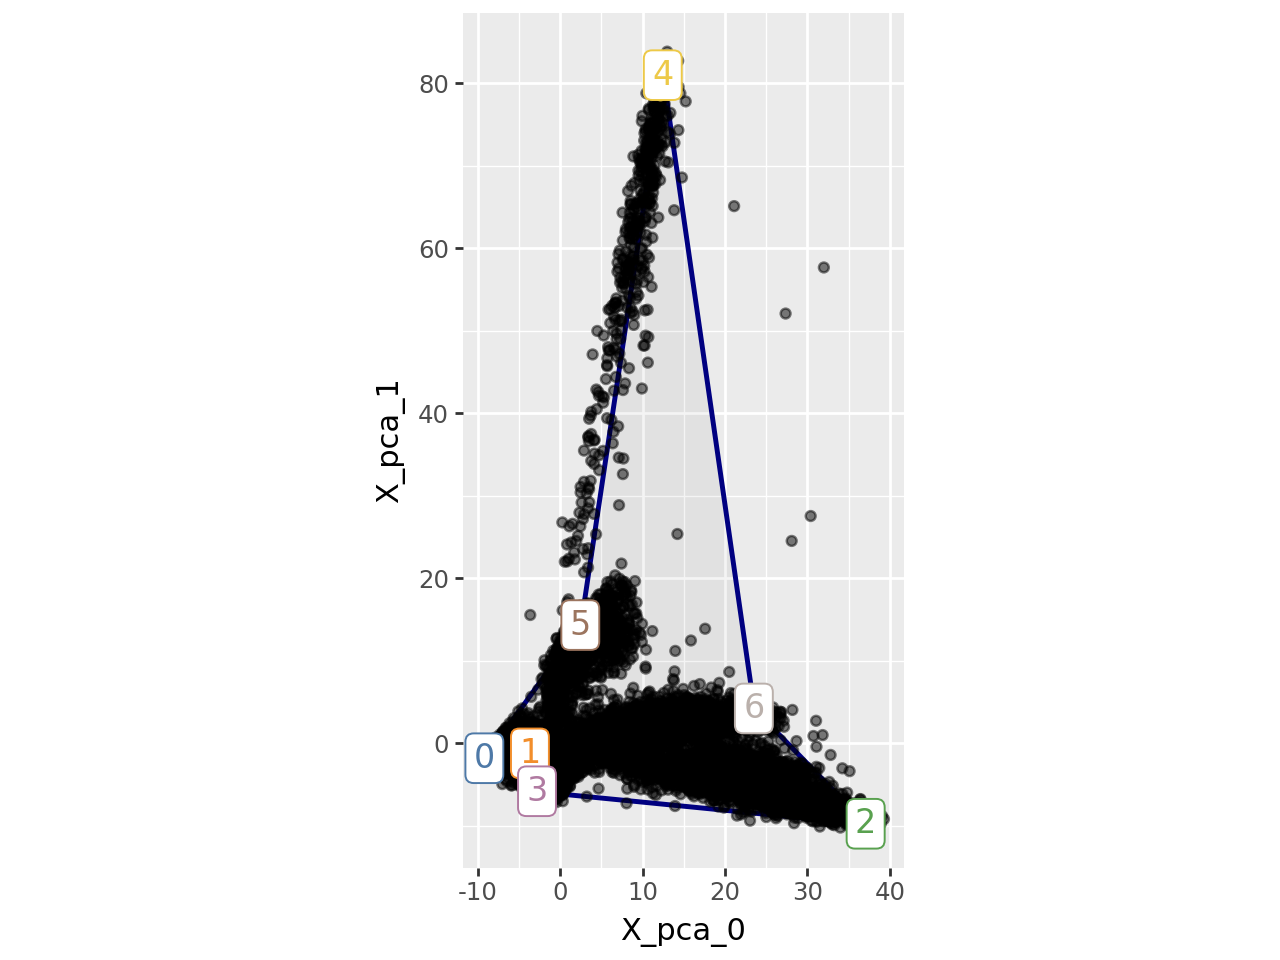

In [135]:
pt.compute_archetypes(adata_bbknn, n_archetypes=7, archetypes_only=False, n_jobs=-1)

pt.plot_archetypes_2D(adata=adata_bbknn, show_contours=True, result_filters={"n_archetypes": 7, "delta": 0.0})

In [136]:
significance = pt.t_ratio_significance(adata_bbknn, result_filters={"n_archetypes": 7, "delta": 0.0}, n_jobs=-1)
significance

Randomizing: 100%|██████████| 100/100 [10:05<00:00,  6.06s/it]


{'t_ratio_p_value': np.float64(0.0), 'rss_p_value': np.float64(0.0)}

In [139]:
arch_idx = 0

In [152]:
weights = pt.get_aa_cell_weights(adata_bbknn, n_archetypes=7, delta=0.0)
print(weights.shape[0])       # число клеток в матрице весов
print(adata_bbknn.n_obs) 



56449
56449


Applied length scale is 12.03.


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


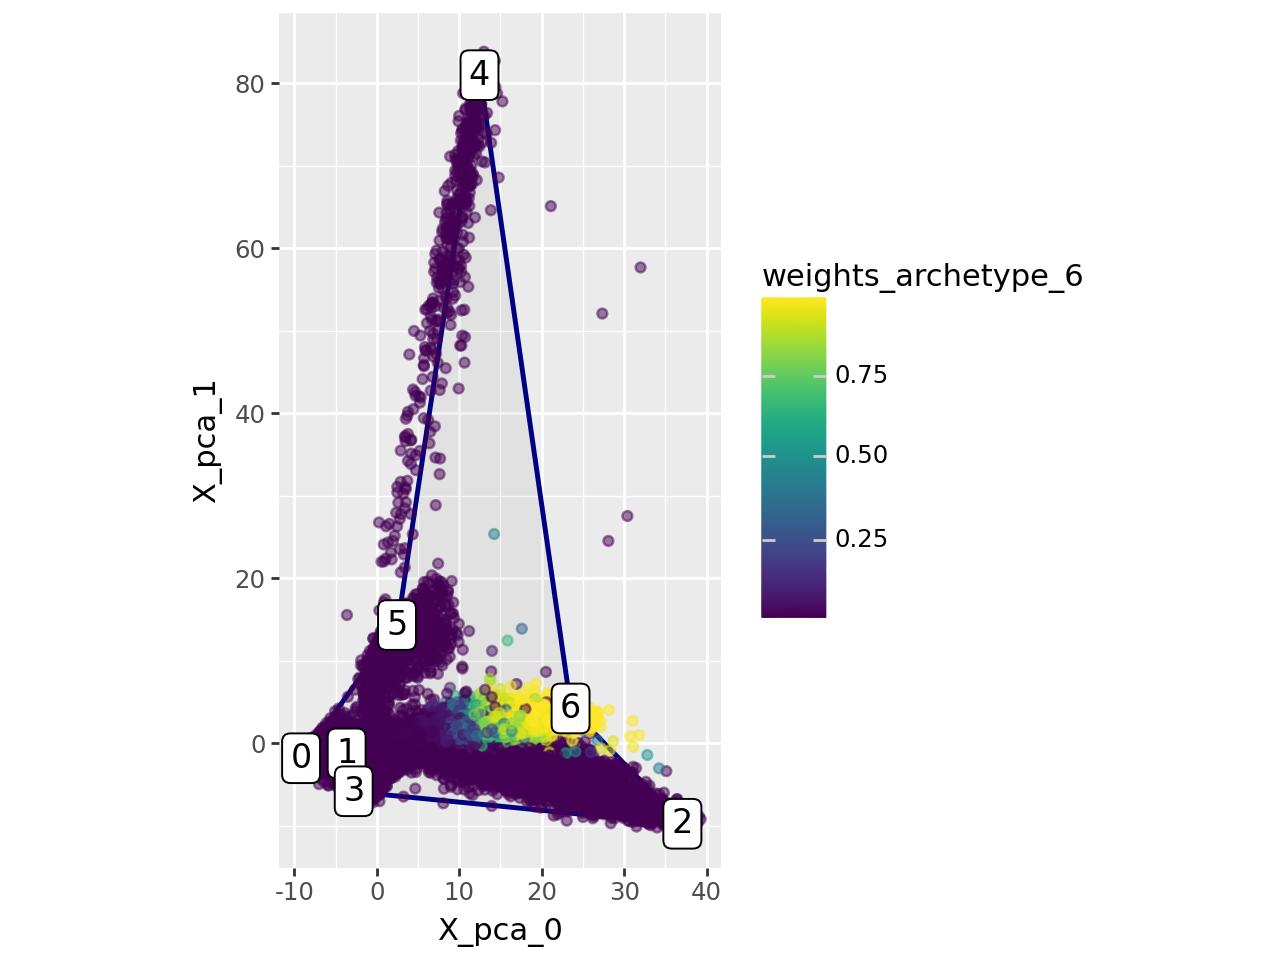

In [177]:
pt.compute_archetype_weights(adata=adata_bbknn, mode="automatic", result_filters={"n_archetypes": 7, "delta": 0.0})
archetype_expression = pt.compute_archetype_expression(adata=adata_bbknn, layer="z_scaled", result_filters={"n_archetypes": 7, "delta": 0.0})

adata_bbknn.obs[f"weights_archetype_{arch_idx}"] = pt.get_aa_cell_weights(adata_bbknn, n_archetypes=7, delta=0.0)[:, arch_idx]
pt.plot_archetypes_2D(adata=adata_bbknn, color=f"weights_archetype_{arch_idx}", result_filters={"n_archetypes": 7, "delta": 0.0})

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


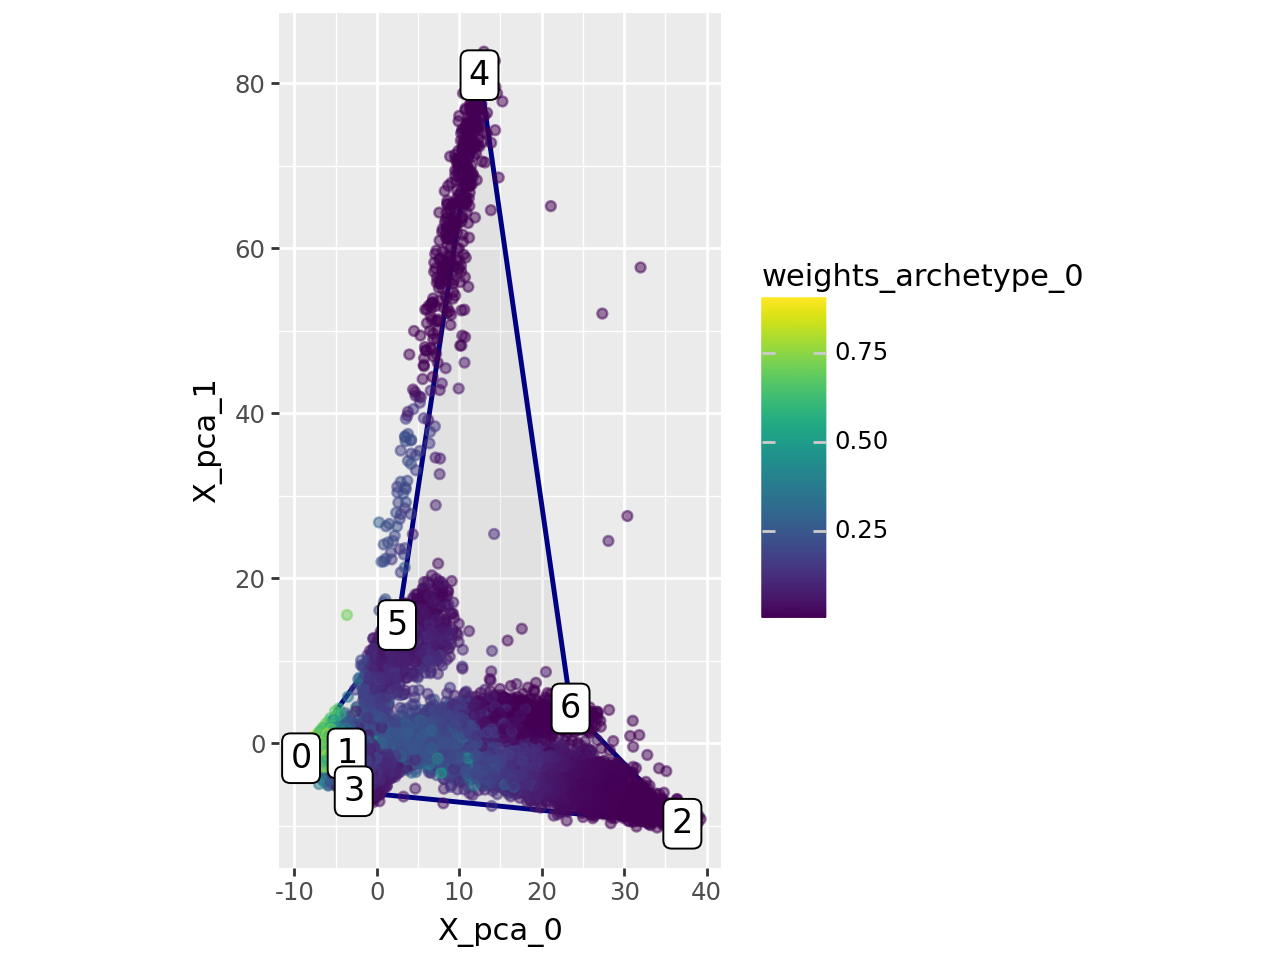

In [164]:

pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_0",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)



c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


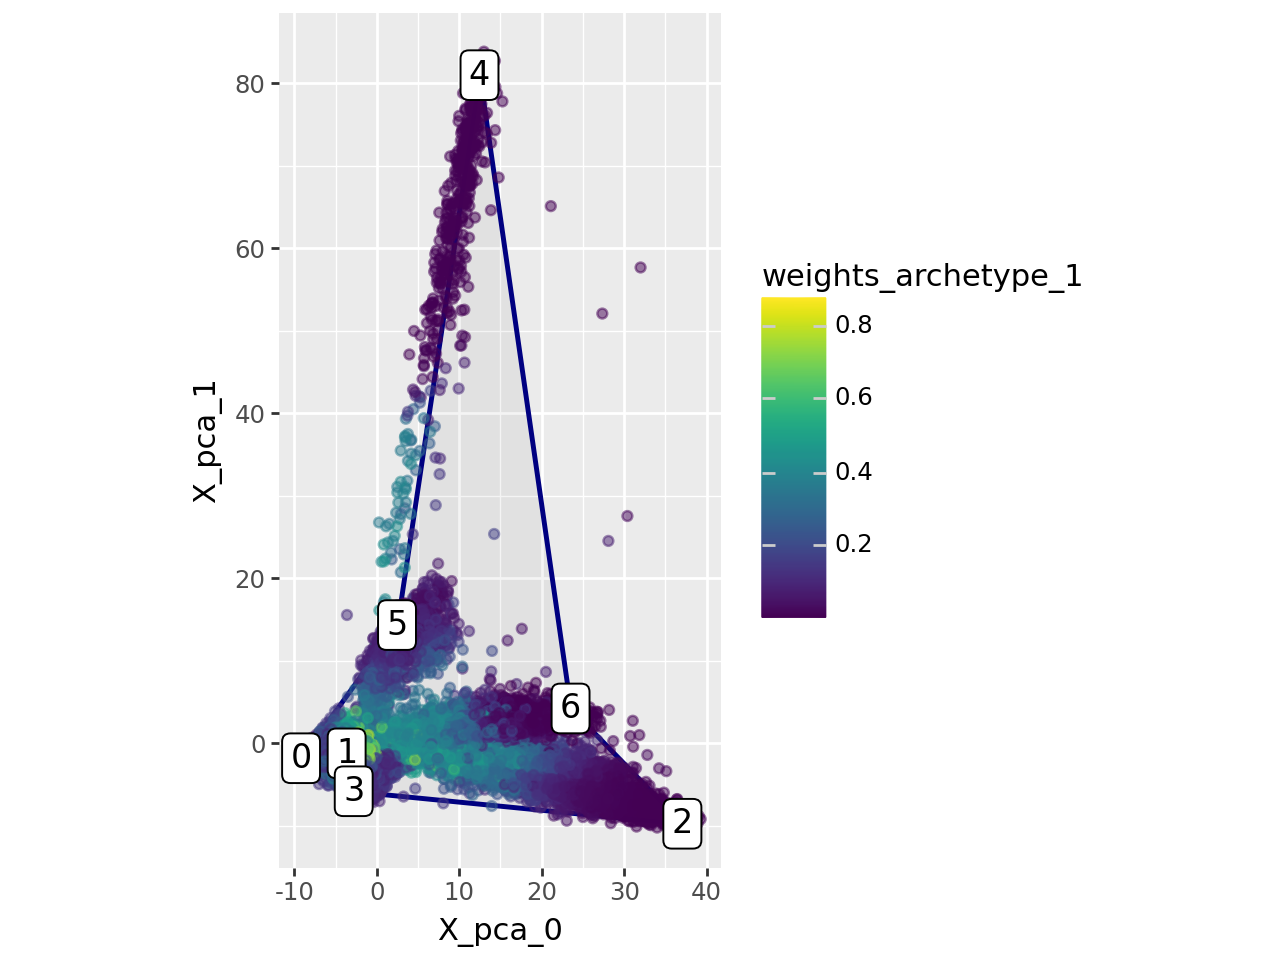

In [165]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_1",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


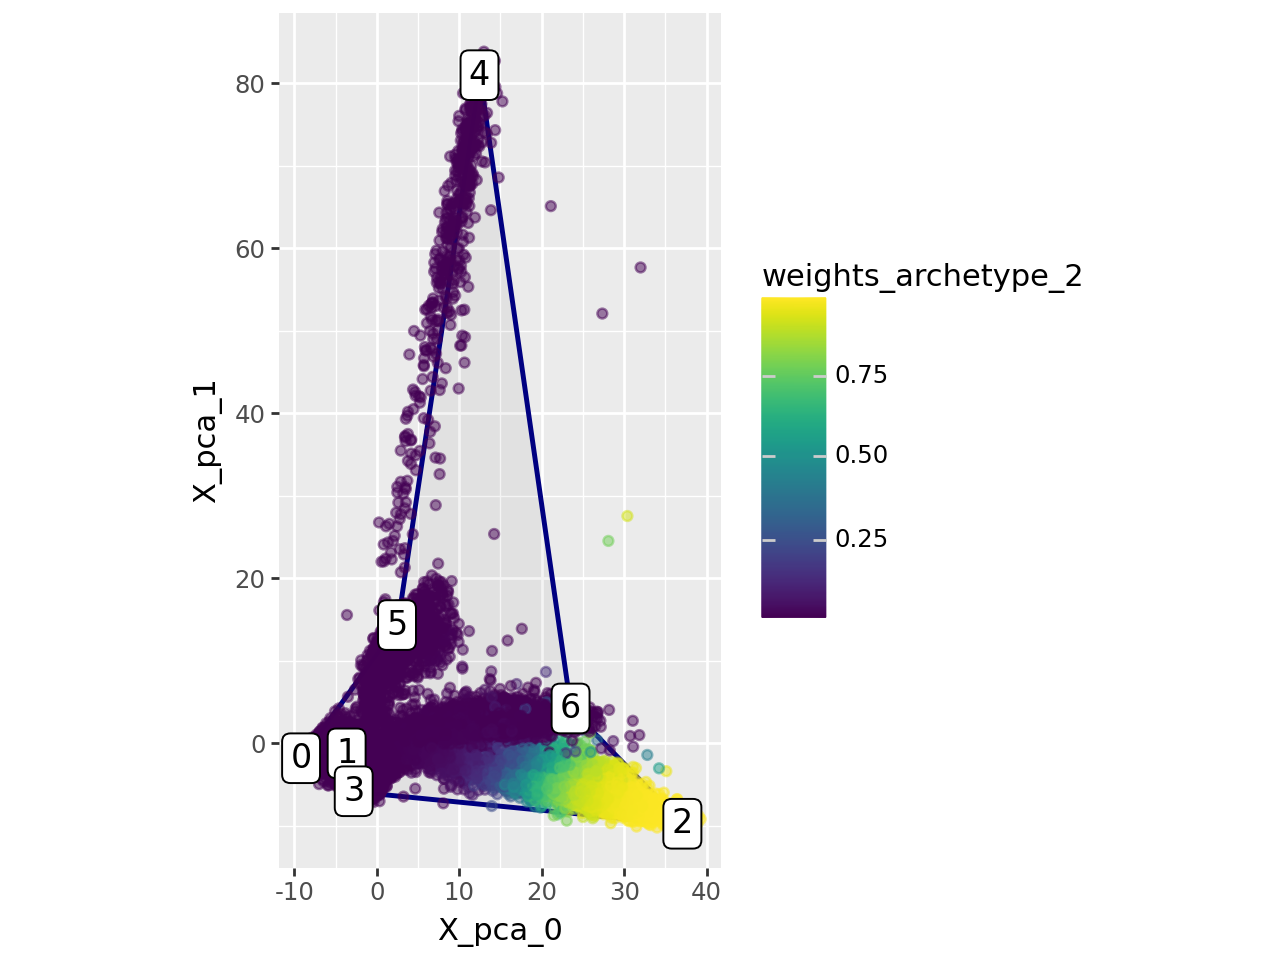

In [166]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_2",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


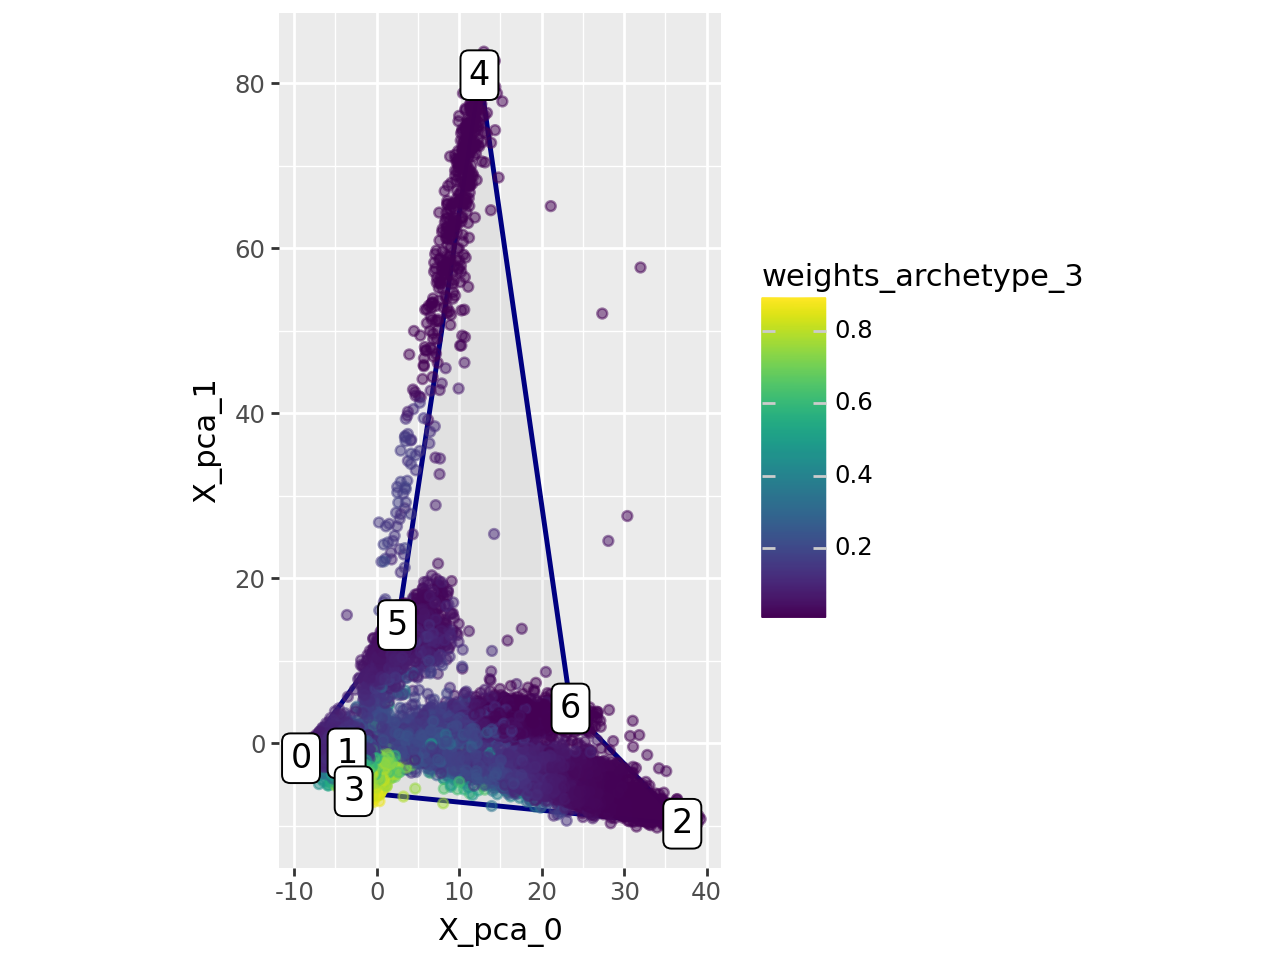

In [167]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_3",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


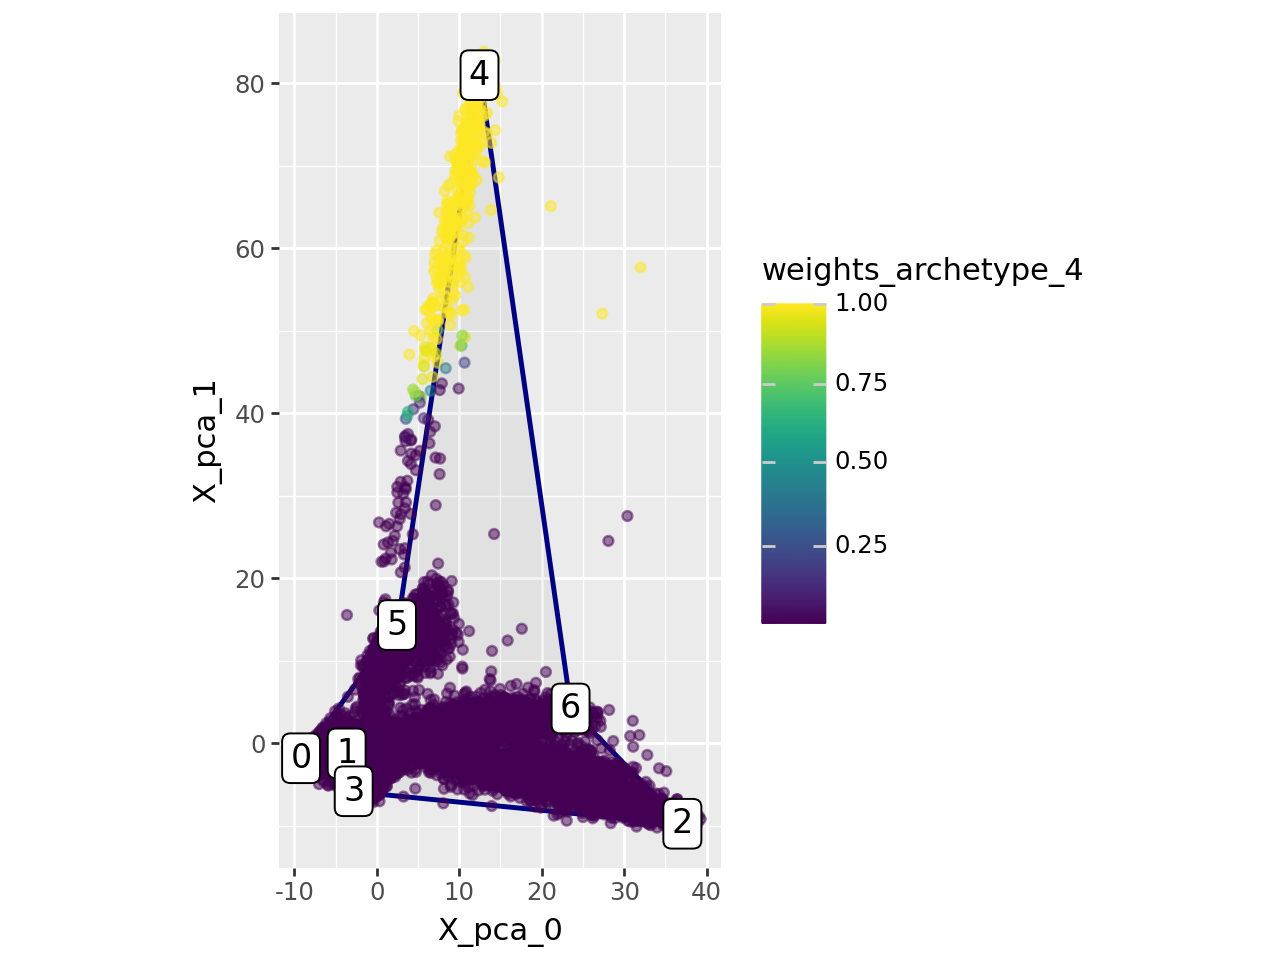

In [168]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_4",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


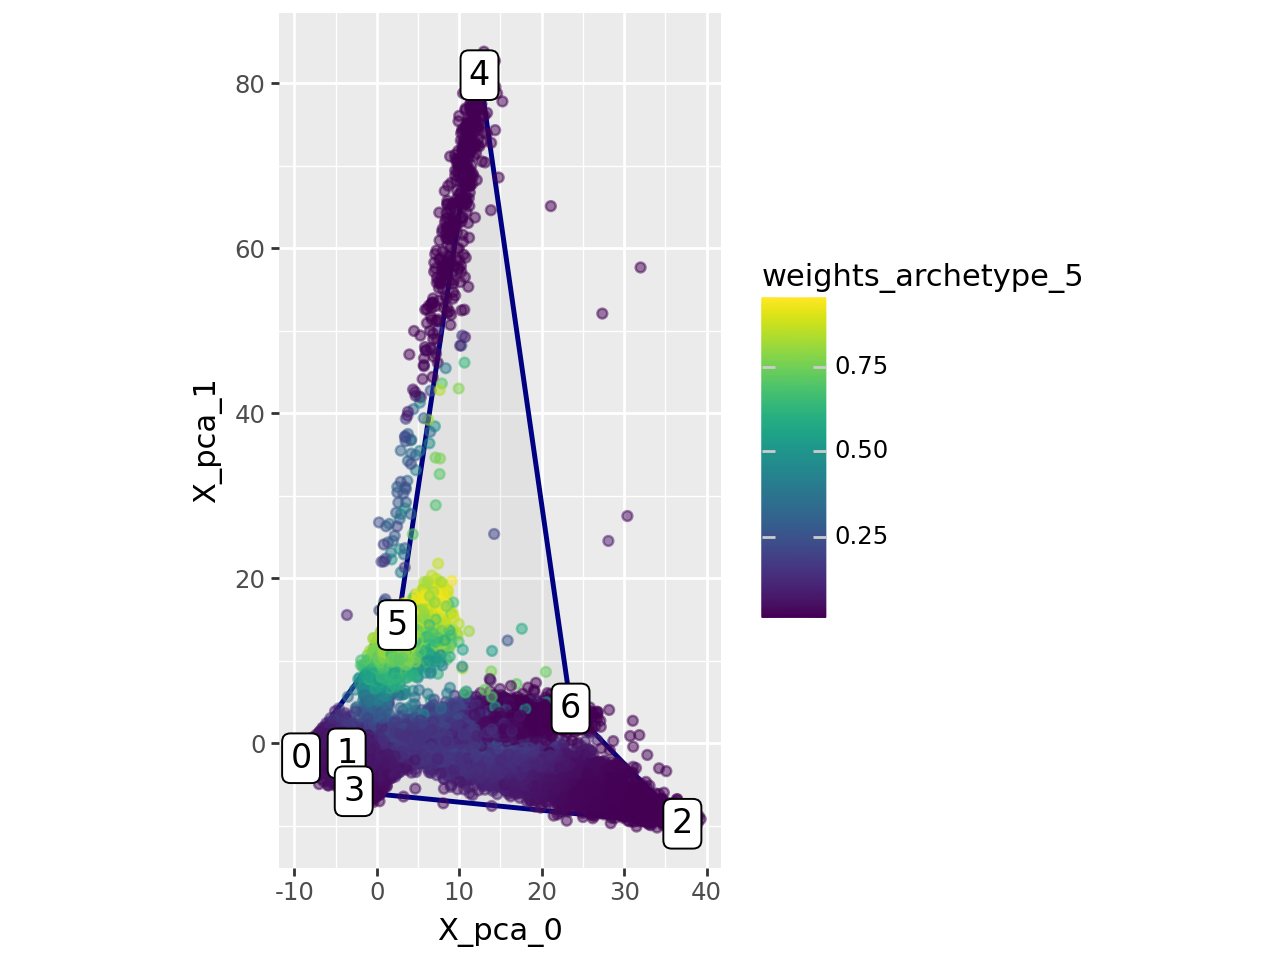

In [169]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_5",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

In [1]:
archetype_expression.T.sort_values(arch_idx, ascending=False).head(10)

NameError: name 'archetype_expression' is not defined